In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import torch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import os
import json
from tqdm import tqdm

import nn_tools as nt 
import data_utils as du

DEVICE = torch.device("mps")
nn_state_path = 'nn_outputs/wilson_csr_CVAE/CVAE_mu_4d.pth'
os.getcwd()

'/Users/Mak/Desktop/Imperial College London/Year Four/MSci Project/Codebase'

In [2]:
def evaluate_model(nn_state_path, eos_csv_path, inputs_json_path, number_bins, device, wc_range_steps=1000):
    """
    Evaluates the model by calculating the Mean Squared Error (MSE) for a range of Wilson Coefficients (WC)
    and plots the variation of MSE with respect to WC.

    Parameters
    ----------
    nn_state_path : str
        Path to the saved model state dictionary.
    eos_csv_path : str
        Path to the CSV file containing the theoretical data (bin heights).
    inputs_json_path : str
        Path to the JSON file containing the input parameters (WC).
    number_bins : int
        Number of bins used in the model.
    device : torch.device
        The device to run the model on (e.g., 'cpu' or 'cuda').
    wc_range_steps : int, optional
        Number of steps in the WC range (default is 1000).

    Returns
    -------
    float
        The predicted Wilson Coefficient with the minimum MSE.
    float
        The actual Wilson Coefficient from the input JSON file.
    np.ndarray
        The array of MSE values for each WC in the range.
    """
    # Initialize the model
    model = nt.base_model(1, number_bins**4).to(device)

    # Load in Theoretical Data and Inputs (WC)
    eos_df = pd.read_csv(eos_csv_path, index_col=0)
    
    with open(inputs_json_path, 'r') as f:
        inputs = json.load(f)

    actual_wc = inputs['wc']
    eos_bin_heights = eos_df['bin_height'].values

    # Create range spanning whole WC limits (0 to 1)
    wc_range = np.linspace(0, 1.0, wc_range_steps)

    pairwise_elements = torch.Tensor(np.array([[value] for value in wc_range])).to(device)

    # Load in model and predict bin height
    model.eval()
    model.load_state_dict(torch.load(nn_state_path, map_location=device, weights_only=False))
    model.to(device)

    with torch.no_grad():
        outputs = model(pairwise_elements)
        outputs = outputs.to('cpu').detach().numpy()

    # Calculate MSE for each of the outputs
    mse_list = []
    for output in outputs:
        mse = np.mean((output - eos_bin_heights)**2)
        mse_list.append(mse)

    # Find the minimum MSE and its associated WC
    mse_np = np.array(mse_list)

    sorted_indices = np.argsort(mse_list)
    arg_min = sorted_indices[0]
    arg_min_2 = sorted_indices[1]

    prediction = wc_range[arg_min]
    prediction_2 = wc_range[arg_min_2]


    return prediction, prediction_2, actual_wc

def wilson_accuracy(nn_state_path, data_path, number_bins, device, self= True, wc_range_steps=1000):
    if self:
        files = glob.glob(os.path.join(data_path, 'model_outputs/*.csv'))
    
    else:
        files = glob.glob(os.path.join(data_path, 'normal_targets/*.csv'))
    filenames = [os.path.splitext(os.path.basename(file))[0] for file in files]

    first_prediction = []
    second_prediction = []
    wcs_obj = []

    for f in tqdm(filenames):
        event_data = data_path + f'/normal_targets/{f}.csv'
        config_data = data_path + f'/normal_inputs/{f}.json'

        prediction, prediction_2, actual_wc = evaluate_model(nn_state_path, event_data, config_data, number_bins, device)
        
        first_prediction.append(prediction)
        second_prediction.append(prediction_2)
        wcs_obj.append(actual_wc)
        
    return first_prediction, second_prediction, wcs_obj

import numpy as np
import matplotlib.pyplot as plt

def QQ_Plot(prediction, objective):
    """
    Generates a QQ plot comparing predicted and actual Wilson coefficients,
    including reflections where necessary and fitting a trend line.

    Parameters
    ----------
    pred : list or np.ndarray
        List or array of predicted Wilson coefficients.
    obj : list or np.ndarray
        List or array of actual Wilson coefficients.
    """
    plt.figure(figsize=(10, 10))

    # Convert lists to NumPy arrays
    objective = np.array(objective)
    prediction = np.array(prediction)

    # Identify conditions for reflection
    mask_1 = (objective < 0.5) & (prediction > 0.5) | (objective > 0.5) & (prediction < 0.5)

    # Create updated prediction lists with reflections where necessary
    pred_updated = np.where(mask_1, 1 - prediction, prediction)

    # Fit the new trend line using updated predictions
    vals = np.polyfit(objective, pred_updated, 1)
    func = np.poly1d(vals)

    # Plot original and reflected points together
    plt.plot(objective, pred_updated, 'x', label='Model Prediction', color='blue')

    # Plot the new trend line
    plt.plot(sorted(objective), func(sorted(objective)), linestyle='dashed', label=f'Gradient: {vals[0]:.2f}, \
             Offset {vals[1]:.2f}', color='black')

    # Labels and styling
    plt.xlabel('Actual Wilson Coefficient')
    plt.ylabel('Predicted Wilson Coefficient')
    plt.title('Model Performance Evaluation')
    plt.legend()
    plt.grid()
    plt.show()

def model_eval_rev(pred_path, obj_path):
    """
    Evaluates the model by comparing predicted Wilson coefficients with true values.

    Parameters
    ----------
    pred_path : str
        Path to the directory containing the predicted Wilson coefficient JSON files.
    obj_path : str
        Path to the directory containing the true Wilson coefficient JSON files.

    Returns
    -------
    tuple
        A tuple containing two lists: predicted Wilson coefficients and true Wilson coefficients.
    """
    file_list = glob.glob(os.path.join(pred_path, '*.json'))

    pred = []
    obj = []

    for fname in tqdm(file_list):
        f_base = os.path.basename(fname)
        obj_file = os.path.join(obj_path, f_base)

        with open(fname, 'r') as f:
            wilson_pred = json.load(f)
        
        with open(obj_file, 'r') as o_f:
            wilson_true = json.load(o_f)
        
        pred.append(wilson_pred[0][0])
        obj.append(wilson_true['wc_0'])

    return pred, obj

# Example usage


In [3]:
normal_path = 'nn_outputs/wilson_csr_fit'
raw_path = 'raw_data/dstore_csr_fit'
number_bins = 10
test_amt = 250

du.file_to_normalise_4d(raw_path, normal_path, number_bins, bkg=True)

# train_inputs, train_targets, test_inputs, test_targets, file_names = du.load_minmax_heights(normal_path, test_amt)

Processing File No. model_WET_mu_102: 100%|██████████| 250/250 [00:31<00:00,  8.00it/s]


100%|██████████| 104/104 [00:13<00:00,  7.63it/s]


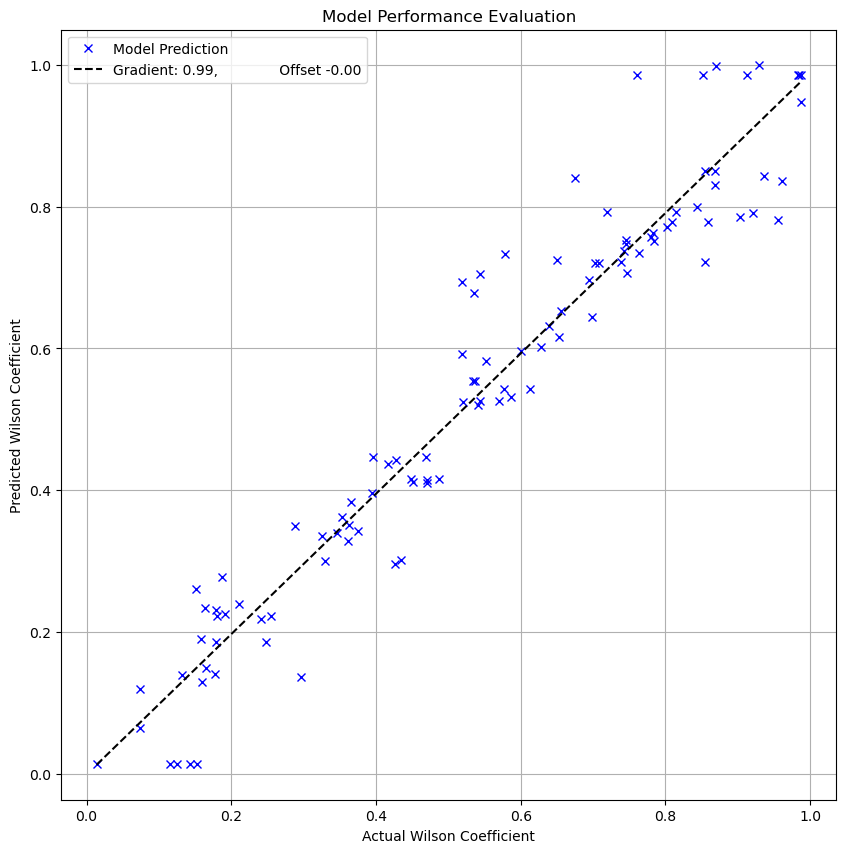

In [21]:
number_bins=10
pred_1, pred_2, obj = wilson_accuracy(nn_state_path, 'nn_outputs/wilson_csr_bkg', number_bins, DEVICE, self=True)
QQ_Plot(pred_1, obj)

100%|██████████| 240/240 [00:00<00:00, 3083.21it/s]


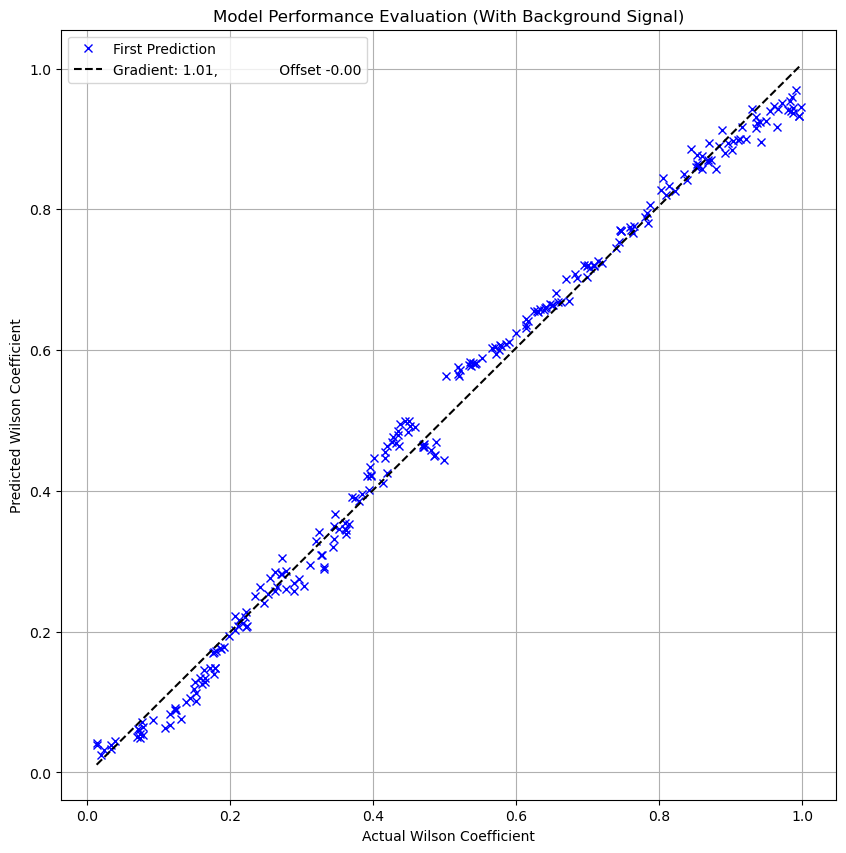

In [17]:
# Example usage
pred_path = 'nn_outputs/wilson_csr_rev/model_outputs'
obj_path = 'nn_outputs/wilson_csr_rev/normal_inputs'
pred, obj = model_eval_rev(pred_path, obj_path)
QQ_Plot(pred, obj)

## Rough Work 


In [ ]:
number_bins=10
model = nt.base_model(1, number_bins**4)

# - Load in Theoretical Data and Inputs (WC) -
eos_df = pd.read_csv('nn_outputs/wilson_csr_fit/normal_targets/model_WET_mu_10.csv', index_col=0)

with open('nn_outputs/wilson_csr_fit/normal_inputs/model_WET_mu_10.json', 'r') as f:
    inputs = json.load(f)

actual_wc = inputs['wc']
eos_bin_heights = eos_df['bin_height'].values

# - Create range spanning whole WC limits (0 to 1) -
wc_range = np.linspace(0, 1.0, 1000)
pairwise_elements = torch.Tensor(np.array([[value] for value in wc_range])).to(DEVICE)

# - Load in model and predict bin height -
model.eval()
model.load_state_dict(torch.load(nn_state_path, weights_only = False))
model.to(DEVICE)

with torch.no_grad():
    outputs = model(pairwise_elements)
    outputs = outputs.to('cpu').detach().numpy()

# - Calculate MSE for each of the outputs
mse_list = []
for output in outputs:
    mse = np.mean((output - eos_bin_heights)**2)
    mse_list.append(mse)

# - Find the minimum MSE and its associated WC -
arg_min = np.argmin(mse_list)
prediction = wc_range[arg_min]
mse_np = np.array(mse_list)

# - Plot the MSE values -
plt.plot(wc_range, mse_np)
plt.axvline(prediction, color='red', label='Predicted Wilson Coefficient')
plt.axvline(actual_wc, color='blue', label='Actual Wilson Coefficient')
plt.xlabel('Wilson Coefficient (wc_range)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Variation of MSE with Wilson Coefficient')
plt.grid(True)
plt.legend()
plt.show()

